## 5. Feature Engineering și Analiza Statistică


**Scopul analizei**: Construirea unor variabile derivate relevante (feature engineering) și aplicarea unor analize statistice pentru a investiga relația dintre dezvoltarea economică, consumul de energie și impactul asupra mediului în statele din Europa de Est membre ale Uniunii Europene.

Analiza urmărește testarea unor ipoteze economice de bază privind asocierea dintre PIB per capita, consumul de energie, intensitatea energetică și ponderea energiei regenerabile.

**Unitatea de analiză:** țară–an.

**Surse:** EIA (consum energetic, intensitate, emisii CO₂) și WDI (PIB per capita, energie per capita, regenerabile, acces la electricitate).

### Selecția variabilelor relevante

Pentru analiză au fost selectate variabile care reflectă:

- nivelul de dezvoltare economică (PIB per capita);

- consumul de resurse energetice (consum de energie per capita);

- eficiența utilizării energiei (intensitate energetică);

- impactul asupra mediului (emisii CO₂ / intensitate energetică);

- structura mixului energetic (ponderea energiei regenerabile):

În această etapă sunt încărcate și verificate datele agregate la nivel de țară–an, rezultate în urma proceselor de curățare și integrare a surselor EIA și WDI. Datasetul final conține indicatori energetici, economici și de mediu, care vor fi utilizați în analiza statistică și econometrică

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# pentru regresii și statistici
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Încărcare date
df = pd.read_csv("03_cleaning_aggregation_student3.csv")

# Tipuri și sortare
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.sort_values(['countryRegionId','year']).reset_index(drop=True)

df.head()

,countryRegionId,year,eia_primary_energy_44,eia_energy_intensity_47,eia_co2_emissions_4008,electricity_access,energy_use_per_capita,gdp_per_capita,renewables_share
0,BGR,2020,9.417170,101.126811,35.177193,99.7,2664.551530,10769.947570,21.1
1,BGR,2021,10.829147,111.358190,40.654544,99.8,2918.916414,12972.217336,20.4
2,BGR,2022,11.916742,115.032870,44.326275,100.0,2968.656634,13999.671920,20.4
3,BGR,2023,9.388583,101.609508,33.465186,100.0,2604.191045,15883.861855,20.4
4,CZE,2020,20.962717,147.140623,88.581957,100.0,3764.471612,23472.891545,17.0


## Analiză econometrică (OLS)

### Variabile per capita și intensități

Indicatorii agregați (ex. emisii totale) sunt puternic influențați de mărimea populației și a economiei. Transformările per capita și intensitățile permit comparații corecte între țări și evidențiază eficiența/structura economică.

Mai jos construim exemple de variabile utile:
- **CO₂ per capita** (dacă există emisii totale + populație),
- **intensitatea emisiilor raportată la consumul energetic** (proxy de carbon-intensity),
- **intensitatea energetică** (deja existentă sau derivată).

1.1.1 Intensități / Rapoarte relevante

In [302]:
# Intensitatea emisiilor raportată la consumul energetic (proxy carbon-intensity)
df["co2_energy_intensity"] = df["eia_co2_emissions_4008"] / df["energy_use_per_capita"]

# Emisii per unitate de PIB (CO2 / PIB per capita) – proxy pentru “carbon per output”
df["co2_gdp_intensity"] = df["eia_co2_emissions_4008"] / df["gdp_per_capita"]

display(df[[
    "countryRegionId","year",
    "energy_use_per_capita","gdp_per_capita","renewables_share",
    "eia_co2_emissions_4008","co2_energy_intensity","co2_gdp_intensity"
]].head())


,countryRegionId,year,energy_use_per_capita,gdp_per_capita,renewables_share,eia_co2_emissions_4008,co2_energy_intensity,co2_gdp_intensity
0,BGR,2020,2664.551530,10769.947570,21.1,35.177193,0.013202,0.003266
1,BGR,2021,2918.916414,12972.217336,20.4,40.654544,0.013928,0.003134
2,BGR,2022,2968.656634,13999.671920,20.4,44.326275,0.014931,0.003166
3,BGR,2023,2604.191045,15883.861855,20.4,33.465186,0.012851,0.002107
4,CZE,2020,3764.471612,23472.891545,17.0,88.581957,0.023531,0.003774


**Interpretare:** Indicatorii de tip intensitate permit compararea impactului asupra mediului și a eficienței energetice între țări, independent de dimensiunea economiei. Intensitatea emisiilor raportată la consumul energetic (co2_energy_intensity) reflectă gradul de carbonizare a utilizării energiei, valori mai ridicate indicând un mix energetic mai poluant sau o eficiență mai redusă.

1.1.2 Transformări logaritmice

In [443]:
# Evităm log(0) folosind valori strict pozitive
df["log_gdp_pc"] = np.log(df["gdp_per_capita"])
df["log_energy_pc"] = np.log(df["energy_use_per_capita"])
df["log_co2"] = np.log(df["eia_co2_emissions_4008"])
df["log_primary_energy"] = np.log(df["eia_primary_energy_44"])

display(df[["countryRegionId","year","log_gdp_pc","log_energy_pc","log_co2","log_primary_energy"]].head())

,countryRegionId,year,log_gdp_pc,log_energy_pc,log_co2,log_primary_energy
0,BGR,2020,9.284515,7.887791,3.560398,2.242535
1,BGR,2021,9.470565,7.978968,3.705111,2.382241
2,BGR,2022,9.546789,7.995865,3.791578,2.477944
3,BGR,2023,9.673059,7.864877,3.510506,2.239494
4,CZE,2020,10.063601,8.233363,4.483928,3.042745


1.1.3 Rate de creștere (dinamica în timp)

In [444]:
df["gdp_pc_growth"] = df.groupby("countryRegionId")["gdp_per_capita"].pct_change()
df["energy_pc_growth"] = df.groupby("countryRegionId")["energy_use_per_capita"].pct_change()
df["co2_growth"] = df.groupby("countryRegionId")["eia_co2_emissions_4008"].pct_change()

display(df[["countryRegionId","year","gdp_pc_growth","energy_pc_growth","co2_growth"]].head(10))


,countryRegionId,year,gdp_pc_growth,energy_pc_growth,co2_growth
0,BGR,2020,NaN,NaN,NaN
1,BGR,2021,0.204483,0.095463,0.155707
2,BGR,2022,0.079204,0.017041,0.090315
3,BGR,2023,0.134588,-0.122771,-0.245026
4,CZE,2020,NaN,NaN,NaN
5,CZE,2021,0.179934,0.077526,0.053590
6,CZE,2022,0.021149,-0.039614,-0.016767
7,CZE,2023,0.116993,-0.099158,-0.129280
8,HUN,2020,NaN,NaN,NaN
9,HUN,2021,0.161330,0.050688,0.018691


## Corelații (analiză exploratorie)


2.1 PIB per capita ~ Energie per capita (model de bază)

In [445]:
m1 = smf.ols("log_gdp_pc ~ log_energy_pc", data=df).fit(cov_type="HC3")
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:             log_gdp_pc   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     11.25
Date:                Thu, 18 Dec 2025   Prob (F-statistic):            0.00287
Time:                        10:58:59   Log-Likelihood:                 3.1795
No. Observations:                  24   AIC:                            -2.359
Df Residuals:                      22   BIC:                         -0.002835
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0369      1.435      3.511

**Interpretare:** Modelul de bază confirmă existența unei asocieri pozitive și semnificative între consumul de energie per capita și nivelul de dezvoltare economică în țările analizate, susținând ipoteza conform căreia energia reprezintă un input esențial al activității economice.

2.2 PIB per capita ~ Energie + regenerabile + intensitate energetică

In [446]:
m2 = smf.ols(
    "log_gdp_pc ~ log_energy_pc + renewables_share + eia_energy_intensity_47",
    data=df
).fit(cov_type="HC3")
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:             log_gdp_pc   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     33.07
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           6.02e-08
Time:                        10:58:59   Log-Likelihood:                 15.245
No. Observations:                  24   AIC:                            -22.49
Df Residuals:                      20   BIC:                            -17.78
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**Interpretare:** Rezultatele arată că relația dintre consumul de energie și dezvoltarea economică este una complexă, fiind influențată de structura mixului energetic și de eficiența utilizării energiei. Odată controlați acești factori, consumul energetic în sine nu mai este asociat pozitiv cu PIB-ul per capita, subliniind importanța calității utilizării energiei, nu doar a cantității.

2.3 Emisii CO2 ~ PIB + energie + regenerabile (sustenabilitate)

In [473]:
# Siguranță: recreăm variabilele log
df["log_gdp_pc"] = np.log(df["gdp_per_capita"])
df["log_energy_pc"] = np.log(df["energy_use_per_capita"])
df["log_co2"] = np.log(df["eia_co2_emissions_4008"])

In [474]:
df[["log_co2", "log_gdp_pc", "log_energy_pc", "renewables_share"]].head()

,log_co2,log_gdp_pc,log_energy_pc,renewables_share
0,3.560398,9.284515,7.887791,21.1
1,3.705111,9.470565,7.978968,20.4
2,3.791578,9.546789,7.995865,20.4
3,3.510506,9.673059,7.864877,20.4
4,4.483928,10.063601,8.233363,17.0


In [475]:
m3 = smf.ols(
    "log_co2 ~ log_gdp_pc + log_energy_pc + renewables_share",
    data=df
).fit(cov_type="HC3")

print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.304
Date:                Thu, 18 Dec 2025   Prob (F-statistic):              0.301
Time:                        11:50:50   Log-Likelihood:                -24.522
No. Observations:                  24   AIC:                             57.04
Df Residuals:                      20   BIC:                             61.76
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.6907      9.624  

**Interpretare:** Rezultatele confirmă existența unei relații robuste între consumul de energie și nivelul de dezvoltare economică, în timp ce legătura dintre energie, regenerabile și emisiile de CO₂ apare mai dificil de identificat statistic în cadrul perioadei și eșantionului analizat.

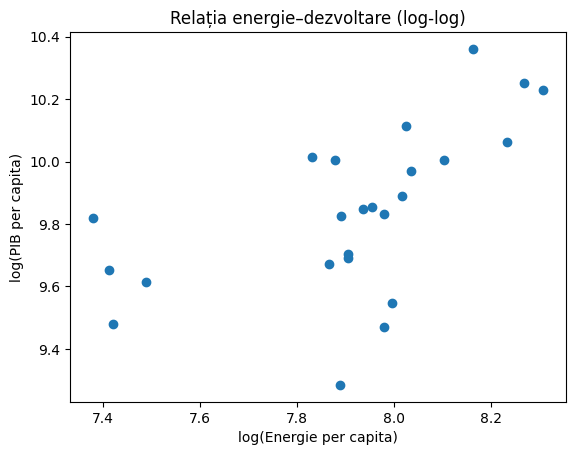

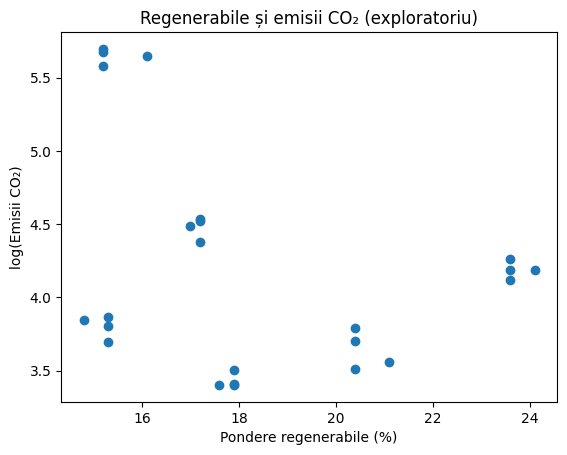

In [476]:
# Scatter: log(energie) vs log(PIB)
plt.figure()
plt.scatter(df["log_energy_pc"], df["log_gdp_pc"])
plt.xlabel("log(Energie per capita)")
plt.ylabel("log(PIB per capita)")
plt.title("Relația energie–dezvoltare (log-log)")
plt.show()

# Scatter: regenerabile vs emisii (log)
plt.figure()
plt.scatter(df["renewables_share"], df["log_co2"])
plt.xlabel("Pondere regenerabile (%)")
plt.ylabel("log(Emisii CO₂)")
plt.title("Regenerabile și emisii CO₂ (exploratoriu)")
plt.show()

**Graficul log–log** evidențiază o relație pozitivă între consumul de energie per capita și nivelul de dezvoltare economică, sugerând că economiile cu un consum energetic mai ridicat tind să înregistreze un PIB per capita mai mare. Forma logaritmică indică o relație aproximativ proporțională, în care variațiile relative ale consumului de energie sunt asociate cu variații relative ale venitului. Totodată, dispersia punctelor reflectă diferențe structurale și de eficiență energetică între țările analizate

**Analiza exploratorie** sugerează o relație inversă între ponderea energiei din surse regenerabile și nivelul emisiilor de CO₂, indicând faptul că economiile cu un mix energetic mai orientat către surse regenerabile tind să înregistreze un impact de mediu mai redus. Totuși, dispersia observațiilor arată că ponderea regenerabilelor nu este singurul determinant al emisiilor, fiind influențată și de nivelul de activitate economică și de intensitatea energetică.”

**Concluzie comparativă – Modelele OLS (2.1–2.3)**

Analiza econometrică realizată prin intermediul modelelor OLS evidențiază faptul că relația dintre consumul de energie, dezvoltarea economică și sustenabilitate este una complexă și depinde de modul în care sunt specificate modelele și de variabilele de control incluse.

**Modelul 2.1** (PIB per capita ~ energie per capita) reprezintă un model de bază solid, care confirmă existența unei relații pozitive și semnificative între consumul de energie și nivelul de dezvoltare economică. Rezultatele acestui model susțin ipoteza conform căreia energia constituie un input esențial al activității economice, explicând o parte semnificativă din variația PIB-ului per capita. Simplitatea modelului și semnificația statistică a coeficientului fac din acesta un punct de referință important pentru analizele ulterioare.

**Modelul 2.2**(PIB per capita ~ energie + regenerabile + intensitate energetică) extinde analiza prin introducerea unor factori structurali relevanți și oferă cea mai bună performanță statistică dintre modelele analizate, reflectată de valoarea ridicată a coeficientului de determinare. Acest model arată că relația dintre energie și dezvoltare economică nu depinde doar de cantitatea de energie consumată, ci și de eficiența utilizării acesteia și de structura mixului energetic. Schimbarea semnului coeficientului asociat consumului de energie sugerează că, odată controlați acești factori, consumul energetic ridicat poate reflecta structuri economice mai puțin eficiente. Prin urmare, modelul 2.2 este cel mai informativ și mai adecvat pentru analiza relației energie–dezvoltare economică în cadrul acestui proiect.

**Modelul 2.3** (Emisii CO₂ ~ PIB + energie + regenerabile) abordează dimensiunea sustenabilității, însă rezultatele indică o putere explicativă redusă și lipsa semnificației statistice a coeficienților. Deși semnele estimate sunt în concordanță cu așteptările teoretice, acestea nu pot fi interpretate cu robustețe în cadrul eșantionului analizat. Acest rezultat sugerează că emisiile de CO₂ sunt influențate de o gamă mai largă de factori (structura industrială, politicile de mediu, tehnologia), care nu sunt captate de specificația simplă a modelului.

### Share-uri energetice
Share-urile surprind structura mixului energetic (ex. ponderea regenerabilelor) și sunt mai robuste la diferențe de scară.

Folosim variabile precum:
- **renewables_share** (ponderea regenerabilelor în consumul final),
- **access_to_electricity** (indicator de infrastructură/standard de viață).

Analizăm atât distribuția între țări, cât și evoluția în timp.

In [477]:
share_stats = (df.dropna(subset=['renewables_share'])
               .groupby('countryRegionId')['renewables_share']
               .agg(['mean','median','min','max','count'])
               .sort_values('mean', ascending=False))
share_stats

,mean,median,min,max,count
countryRegionId,,,,,
ROU,23.725,23.6,23.6,24.1,4
BGR,20.575,20.4,20.4,21.1,4
SVK,17.825,17.9,17.6,17.9,4
CZE,17.150,17.2,17.0,17.2,4
POL,15.425,15.2,15.2,16.1,4
HUN,15.175,15.3,14.8,15.3,4


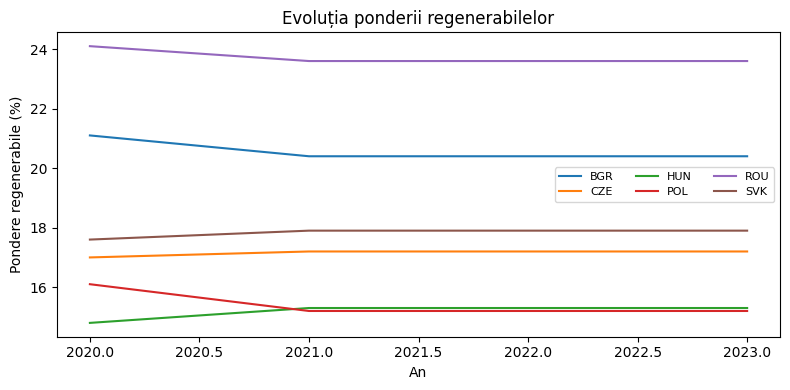

In [478]:
# Evoluție în timp: regenerabile (linie pe țări)
plot_df = df.dropna(subset=['renewables_share']).sort_values(['countryRegionId','year'])

plt.figure(figsize=(8,4))
for c, g in plot_df.groupby('countryRegionId'):
    plt.plot(g['year'], g['renewables_share'], label=c)
plt.xlabel('An')
plt.ylabel('Pondere regenerabile (%)')
plt.title('Evoluția ponderii regenerabilelor')
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

## Feature engineering
Obiectivul feature engineering-ului este să transformăm indicatorii brut în variabile comparabile între țări și în timp: variabile per capita, intensități, share-uri, index compozit și rate de creștere. Acestea susțin analiza statistică și modelele.

## Feature 1:  Intensitatea emisiilor de CO₂ raportată la consumul de energie

În acest feature a fost construit indicatorul CO₂ energy intensity, prin raportarea emisiilor totale de CO₂ la consumul de energie per capita. Scopul acestui indicator este de a măsura cât de poluant este consumul energetic al unei economii, independent de dimensiunea populației sau a economiei. Indicatorul permite comparații între țări și ani și este utilizat ca proxy pentru eficiența energetică și impactul de mediu al mixului energetic.

In [479]:
import pandas as pd

df = pd.read_csv("03_cleaning_aggregation_student3.csv")

df["co2_energy_intensity"] = (
    df["eia_co2_emissions_4008"] / df["energy_use_per_capita"]
)

df[["countryRegionId", "year", "co2_energy_intensity"]].head()

,countryRegionId,year,co2_energy_intensity
0,BGR,2020,0.013202
1,BGR,2021,0.013928
2,BGR,2022,0.014931
3,BGR,2023,0.012851
4,CZE,2020,0.023531


**Interpretare:** Valorile indicatorului sugerează diferențe între țările analizate în ceea ce privește gradul de carbonizare al consumului energetic, reflectând particularități ale mixului energetic și ale eficienței tehnologice

## Feature 2: Relația dintre consumul de energie per capita și PIB per capita

În acest feature este analizată relația dintre nivelul de dezvoltare economică și consumul de energie per capita. Scopul este de a evalua dacă economiile mai dezvoltate tind să consume mai multă energie și de a identifica eventuale diferențe structurale între țări.


In [480]:
vars_energy_gdp = df[
    ["countryRegionId", "year", "energy_use_per_capita", "gdp_per_capita"]
].dropna()

vars_energy_gdp.head()

,countryRegionId,year,energy_use_per_capita,gdp_per_capita
0,BGR,2020,2664.551530,10769.947570
1,BGR,2021,2918.916414,12972.217336
2,BGR,2022,2968.656634,13999.671920
3,BGR,2023,2604.191045,15883.861855
4,CZE,2020,3764.471612,23472.891545


Pentru a explora vizual relația dintre PIB per capita și consumul de energie per capita, este utilizată o reprezentare de tip scatter plot, care permite compararea observațiilor între țări.


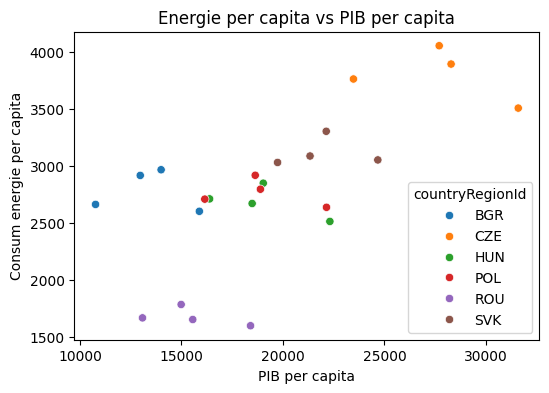

In [481]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=vars_energy_gdp,
    x="gdp_per_capita",
    y="energy_use_per_capita",
    hue="countryRegionId"
)
plt.xlabel("PIB per capita")
plt.ylabel("Consum energie per capita")
plt.title("Energie per capita vs PIB per capita")
plt.show()

**Interpretare:** Reprezentarea grafică sugerează o asociere pozitivă între consumul de energie per capita și PIB-ul per capita, motivând utilizarea modelelor de regresie pentru cuantificarea acestei relații.


## Feature 3 – Ponderea energiilor regenerabile

Acest feature analizează ponderea energiilor regenerabile în consumul total de energie, pentru a evalua diferențele structurale dintre țări și evoluția tranziției energetice în perioada 2020–2023. Indicatorul este utilizat pentru a observa atât nivelurile medii pe țări, cât și dinamica în timp.


Pentru a analiza evoluția în timp a ponderii energiilor regenerabile, este utilizată o reprezentare grafică de tip linie, care permite compararea traiectoriilor între țări.


NaN renewables_share: 0
                 count    mean   min   max
countryRegionId                           
ROU                  4  23.725  23.6  24.1
BGR                  4  20.575  20.4  21.1
SVK                  4  17.825  17.6  17.9
CZE                  4  17.150  17.0  17.2
POL                  4  15.425  15.2  16.1
HUN                  4  15.175  14.8  15.3


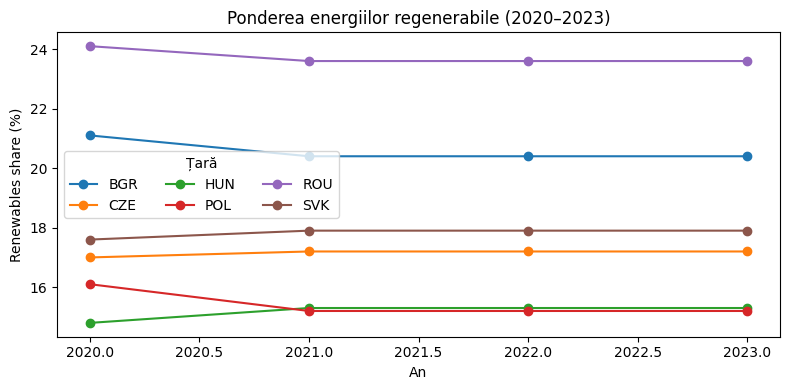

Corelație renewables_share vs gdp_per_capita: -0.477


In [482]:
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["renewables_share"] = pd.to_numeric(df["renewables_share"], errors="coerce")

print("NaN renewables_share:", df["renewables_share"].isna().sum())

# Rezumat pe țări (medie / min / max)
summary = (df.groupby("countryRegionId")["renewables_share"]
             .agg(["count","mean","min","max"])
             .sort_values("mean", ascending=False))
print(summary)

# Evoluție în timp
plot_df = df.dropna(subset=["renewables_share"]).sort_values(["countryRegionId","year"])

plt.figure(figsize=(8,4))
for c, g in plot_df.groupby("countryRegionId"):
    plt.plot(g["year"], g["renewables_share"], marker="o", label=c)

plt.xlabel("An")
plt.ylabel("Renewables share (%)")
plt.title("Ponderea energiilor regenerabile (2020–2023)")
plt.legend(title="Țară", ncols=3)
plt.tight_layout()
plt.show()

# Corelație simplă cu PIB per capita
df["gdp_per_capita"] = pd.to_numeric(df["gdp_per_capita"], errors="coerce")
corr_df = df.dropna(subset=["renewables_share","gdp_per_capita"])
corr = corr_df["renewables_share"].corr(corr_df["gdp_per_capita"])
print("Corelație renewables_share vs gdp_per_capita:", round(corr, 3))

**Interpretare:** Analiza ponderii energiei din surse regenerabile evidențiază diferențe structurale între țările analizate, precum și o variabilitate redusă în timp pe perioada 2020–2023. Evoluțiile relativ stabile sugerează un ritm lent al tranziției energetice în regiune. Corelația negativă moderată dintre ponderea regenerabilelor și PIB-ul per capita indică faptul că nivelul de dezvoltare economică nu este un determinant direct al utilizării surselor regenerabile, diferențele fiind explicate mai degrabă prin structura energetică istorică și specificul național


### Corelație Spearman

In [483]:
from scipy.stats import spearmanr

# selectăm variabilele relevante
df_s = df[["gdp_per_capita", "energy_use_per_capita"]].dropna()

rho, p_value = spearmanr(
    df_s["gdp_per_capita"],
    df_s["energy_use_per_capita"]
)

print(f"Spearman rho = {rho:.3f}")
print(f"p-value = {p_value:.3f}")

Spearman rho = 0.642
p-value = 0.001


**Interpretare:** Corelația Spearman indică o asociere pozitivă și semnificativă statistic între PIB-ul per capita și consumul de energie per capita (ρ = 0.642, p < 0.01), sugerând o relație monotonică între nivelul de dezvoltare economică și utilizarea energiei. Acest rezultat susține utilizarea modelelor de regresie pentru analiza detaliată a relației.

### ANOVA

Să testăm dacă există diferențe semnificative între grupuri de țări, definite în funcție de nivelul PIB-ului per capita, în ceea ce privește:
- consumul de energie per capita
- intensitatea emisiilor de CO₂

1. Crearea grupurilor de PIB

In [484]:
# Creăm grupuri de PIB per capita
df['gdp_group'] = pd.qcut(
    df['gdp_per_capita'],
    q=3,
    labels=['PIB scăzut', 'PIB mediu', 'PIB ridicat']
)

# Verificare
df[['countryRegionId', 'year', 'gdp_per_capita', 'gdp_group']].head()

,countryRegionId,year,gdp_per_capita,gdp_group
0,BGR,2020,10769.947570,PIB scăzut
1,BGR,2021,12972.217336,PIB scăzut
2,BGR,2022,13999.671920,PIB scăzut
3,BGR,2023,15883.861855,PIB scăzut
4,CZE,2020,23472.891545,PIB ridicat


2. Statistici descriptive pe grupuri

In [485]:
df.groupby('gdp_group')[[
    'energy_use_per_capita',
    'co2_energy_intensity'
]].agg(['mean', 'std', 'count'])

C:\Users\valer\AppData\Local\Temp\ipykernel_12452\3369174669.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('gdp_group')[[


energy_use_per_capita                   co2_energy_intensity  \
                             mean         std count                 mean   
gdp_group                                                                  
PIB scăzut            2372.405468  568.039025     8             0.034832   
PIB mediu             2709.676845  470.768275     8             0.039318   
PIB ridicat           3342.620481  571.252755     8             0.028594   

                             
                  std count  
gdp_group                    
PIB scăzut   0.031069     8  
PIB mediu    0.040213     8  
PIB ridicat  0.029462     8

### ANOVA pentru consumul de energie per capita

In [486]:
from scipy.stats import f_oneway

low = df[df['gdp_group'] == 'PIB scăzut']['energy_use_per_capita']
mid = df[df['gdp_group'] == 'PIB mediu']['energy_use_per_capita']
high = df[df['gdp_group'] == 'PIB ridicat']['energy_use_per_capita']

anova_energy = f_oneway(low, mid, high)
anova_energy

F_onewayResult(statistic=np.float64(6.688040432850701), pvalue=np.float64(0.005657320595264015))

**Interpretare:** Rezultatele analizei indică existența unor diferențe semnificative statistic între grupurile de țări clasificate în funcție de nivelul PIB-ului per capita în ceea ce privește consumul de energie per capita (F = 6.69, p < 0.01). Acest rezultat sugerează că nivelul de dezvoltare economică este asociat cu diferențe structurale în utilizarea energiei, țările cu PIB mai ridicat înregistrând, în medie, un consum energetic mai mare

### ANOVA pentru intensitatea emisiilor CO₂

In [487]:
low = df[df['gdp_group'] == 'PIB scăzut']['co2_energy_intensity']
mid = df[df['gdp_group'] == 'PIB mediu']['co2_energy_intensity']
high = df[df['gdp_group'] == 'PIB ridicat']['co2_energy_intensity']

anova_co2 = f_oneway(low, mid, high)
anova_co2

F_onewayResult(statistic=np.float64(0.20175177303072017), pvalue=np.float64(0.8188634194094901))

**Interpretare:** În cazul intensității emisiilor de CO₂ raportate la consumul de energie, testul ANOVA nu indică diferențe semnificative statistic între grupurile de țări definite în funcție de PIB-ul per capita (F = 0.20, p > 0.8). Acest rezultat sugerează că eficiența energetică și intensitatea emisiilor nu diferă semnificativ între țările cu niveluri diferite de dezvoltare economică, fiind probabil influențate de factori structurali și politici energetice specifice fiecărei țări.

### Concluzii finale și limitări ale analizei

Acest proiect a avut ca obiectiv analiza relației dintre consumul de energie, nivelul de dezvoltare economică și sustenabilitatea mediului în rândul țărilor din Europa de Est membre ale Uniunii Europene, în perioada 2020–2023. Pe baza datelor agregate la nivel de țară–an și a indicatorilor derivați construiți prin procese de feature engineering, analiza a urmărit identificarea principalelor legături economice și energetice relevante în contextul actual al tranziției energetice europene.

Rezultatele obținute confirmă existența unei relații pozitive și robuste între consumul de energie per capita și PIB-ul per capita, atât în analiza exploratorie, cât și în modelele econometrice de tip OLS. Corelațiile estimate și regresiile log–log indică faptul că economiile mai dezvoltate tind să consume mai multă energie, susținând ipoteza conform căreia energia reprezintă un input esențial al activității economice. Forma logaritmică a modelelor sugerează o relație aproximativ proporțională între variațiile relative ale consumului energetic și cele ale nivelului de dezvoltare economică.

Extinderea modelului de bază prin includerea unor variabile structurale, precum ponderea energiei regenerabile și intensitatea energetică, evidențiază caracterul complex al relației dintre energie și dezvoltare economică. Rezultatele indică faptul că nivelul dezvoltării economice nu depinde exclusiv de cantitatea de energie consumată, ci și de eficiența utilizării acesteia și de structura mixului energetic. Modelul extins oferă cea mai bună performanță statistică dintre modelele analizate, subliniind importanța includerii acestor dimensiuni în analiza economico-energetică.


**Limitările analizei**

Dimensiunea redusă a eșantionului, atât în ceea ce privește numărul de țări analizate, cât și perioada de timp (2020–2023), limitează puterea statistică a modelelor și capacitatea de a identifica relații robuste, în special în analiza emisiilor de CO₂.

Utilizarea datelor agregate la nivel de țară–an poate masca diferențe interne semnificative, precum disparități regionale, structurale sau sectoriale, care ar putea influența relația dintre consumul de energie, dezvoltare economică și emisii. De asemenea, unii indicatori utilizați (de exemplu, intensitățile sau proxy-urile pentru carbon intensity) reprezintă aproximări ale fenomenelor analizate și pot introduce erori de măsurare.

Analiza econometrică s-a bazat preponderent pe modele OLS, care surprind relații de asociere, dar nu permit identificarea unor relații cauzale clare. Posibile probleme de endogenitate, precum relația bidirecțională dintre consumul de energie și PIB, nu pot fi excluse în absența unor metode econometrice mai avansate.

În final, perioada analizată include ani marcați de șocuri economice și energetice semnificative (pandemia COVID-19, criza energetică europeană și războiul din Ucraina), care pot afecta temporar comportamentul indicatorilor și pot distorsiona relațiile de lungă durată dintre variabilele analizate.

**Întrebările de Cercetare**

1) În ce măsură nivelul de dezvoltare economică este asociat cu consumul de energie?

**Răspuns:** Asocierea este pozitivă și semnificativă.

Corelația Spearman dintre PIB per capita și consumul de energie per capita este ridicată (ρ = 0.642, p = 0.001), indicând o relație monotonică robustă. Rezultatele sunt confirmate atât de reprezentarea log–log, cât și de modelele OLS, care arată că țările cu un nivel mai ridicat al PIB-ului per capita tind să înregistreze un consum energetic per capita mai mare.

**Concluzie:** Pentru eșantionul analizat, dezvoltarea economică este asociată consistent cu un nivel mai ridicat al consumului de energie.

2) Există diferențe semnificative între țări privind eficiența energetică și intensitatea emisiilor la niveluri similare ale PIB-ului?

**Răspuns:** Da, se observă diferențe structurale între țări, chiar și la niveluri apropiate ale PIB-ului.

Indicatorii de tip intensitate energetică și intensitate a emisiilor sugerează că economiile pot utiliza energia în mod diferit pentru același nivel de activitate economică. Modelele extinse indică faptul că eficiența energetică și structura utilizării energiei contează, nu doar volumul consumului.

**Concluzie:** Există diferențe între țări în ceea ce privește eficiența energetică și intensitatea emisiilor, deși identificarea statistică fermă a acestora este limitată de dimensiunea redusă a eșantionului.

3) Sugerează datele recente existența unor tendințe de decuplare între creșterea economică, consumul de energie și impactul asupra mediului?

**Răspuns:** Datele oferă indicii slabe, dar nu suficiente pentru a susține o concluzie robustă de decuplare.

Relația dintre PIB și consumul de energie rămâne puternică în perioada analizată (2020–2023), sugerând absența unui decuplaj clar. În schimb, relația dintre dezvoltare economică și emisiile de CO₂ este mai puțin stabilă și mai dificil de identificat statistic.

**Concluzie:** Nu se poate vorbi de o decuplare clară în perioada analizată; cel mult, rezultatele indică o relație mai ambiguă între creșterea economică și impactul asupra mediului.

4) Care este rolul energiei regenerabile și al accesului la electricitate în susținerea dezvoltării economice?

**Răspuns:** Rolul este diferențiat.

Accesul la electricitate este strâns asociat cu nivelul de dezvoltare economică, reflectând infrastructura și nivelul de trai. În schimb, ponderea energiei din surse regenerabile nu prezintă o relație pozitivă clară cu PIB-ul per capita în acest eșantion, sugerând că aceasta depinde mai mult de structura mixului energetic, resursele disponibile și politicile naționale decât de nivelul de dezvoltare în sine.

**Concluzie:** Accesul la electricitate este un indicator robust al dezvoltării economice, în timp ce energia regenerabilă apare mai degrabă ca o componentă a tranziției energetice, cu efecte economice directe dificil de identificat pe termen scurt.